In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf #https://anaconda.org/anaconda/statsmodels
import statsmodels.api as sm #https://scikit-posthocs.readthedocs.io/en/latest/installation/
import scikit_posthocs as sp
import seaborn as sns

In [3]:
mobsuite = pd.read_csv("02072023_EcoliARETE_Plasmids_Isolates_All_no_novel_mobsuite_results_SUMS_all_stats.csv")

In [4]:
mobsuite

,Genome,Source,Outbreak,Phylogroup,Total_Plasmids
0,EC_7360_2H2_D,Diseased,F7360,B1,10
1,EC_0731_2H1_D,Diseased,F0731,G,9
2,EC_0731_2S2_D,Diseased,F0731,G,9
3,EC_23315_H1_D,Diseased,F23315,G,9
4,EC_23315_S2_D,Diseased,F23315,G,9
...,...,...,...,...,...
240,EC_E4DI_1_E,Environmental,NaN,U,0
241,EC_E4FP_1_E,Environmental,NaN,A,0
242,EC_E4L_1_E,Environmental,NaN,A,0
243,EC_E4P_1_E,Environmental,NaN,A,0


In [6]:
#strings_to_remove = ['apple', 'banana']

# Filter out rows with strings to remove in Column2
mobsuitephylo = mobsuite[~mobsuite['Phylogroup'].str.contains('U|cryptic|F')]


In [7]:
#One way ANOVA for impact of Sequencing condition on total plasmids in each assembly type
results = []
#'source' is AMR, GI, phage, etc....
for AT in mobsuite['Source'].unique():
    #make the model
    model = smf.ols('Total_Plasmids ~ C(Phylogroup)', data=mobsuitephylo[mobsuitephylo['Source']==AT]).fit()
    #calculate anova. We use type 3 SS in this paper.
    d = sm.stats.anova_lm(model, typ=3)
    # We only care about the F statistic in this case. grab it.
    d = d[['PR(>F)']]
    d.rename({'PR(>F)': "{}_p".format(AT)}, axis=1, inplace=True)
    results.append(d)
#Compile the results into one dataframe
all_r = results[0]
for d in results[1:]:
    all_r = all_r.join(d)
all_r = all_r.dropna().iloc[1:].dropna()[['Diseased_p', 'Cecal_p', 'Environmental_p']]
all_r


,Diseased_p,Cecal_p,Environmental_p
C(Phylogroup),0.014933,0.156543,0.261759


In [8]:
records = []
for AT in mobsuite['Source'].unique(): #AMR, HMR, plasmid, etc...
    # this calculates adjusted p value
    d = sp.posthoc_ttest(mobsuitephylo[mobsuitephylo['Source']==AT],
                 val_col='Total_Plasmids',
                 group_col='Phylogroup',
                 p_adjust='bonferroni')
    #Format the result into a dict
    for i in d.index:
        for j in d.columns:
            records.append({'Feature': AT, 'query': i, 'subject': j, 'P': d.loc[i][j]})
ttests = pd.DataFrame.from_records(records)
ttests.head()

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]


,Feature,query,subject,P
0,Diseased,B1,B1,1.0
1,Diseased,B1,G,1.0
2,Diseased,B1,A,1.0
3,Diseased,B1,B2,1.0
4,Diseased,B1,D,1.0


In [9]:
ttests.to_csv("05292023_EcoliARETE_PlasmidsSourcePhylogroup_ttests.csv")

In [10]:
mobsuitenona=mobsuite.dropna()


In [11]:
#One way ANOVA for impact of Sequencing condition on total plasmids in each assembly type
results = []
#'source' is AMR, GI, phage, etc....
for AT in mobsuitenona['Source'].unique():
    #make the model
    model = smf.ols('Total_Plasmids ~ C(Outbreak)', data=mobsuitenona[mobsuitenona['Source']==AT]).fit()
    #calculate anova. We use type 3 SS in this paper.
    d = sm.stats.anova_lm(model, typ=3)
    # We only care about the F statistic in this case. grab it.
    d = d[['PR(>F)']]
    d.rename({'PR(>F)': "{}_p".format(AT)}, axis=1, inplace=True)
    results.append(d)
#Compile the results into one dataframe
all_r = results[0]
for d in results[1:]:
    all_r = all_r.join(d)
all_r = all_r.dropna().iloc[1:].dropna()[['Diseased_p', 'Cecal_p']]
all_r

,Diseased_p,Cecal_p
C(Outbreak),0.000004,0.006298


In [12]:
records = []
for AT in mobsuitenona['Source'].unique(): #AMR, HMR, plasmid, etc...
    # this calculates adjusted p value
    d = sp.posthoc_ttest(mobsuitenona[mobsuitenona['Source']==AT],
                 val_col='Total_Plasmids',
                 group_col='Outbreak',
                 p_adjust='bonferroni')
    #Format the result into a dict
    for i in d.index:
        for j in d.columns:
            records.append({'Feature': AT, 'query': i, 'subject': j, 'P': d.loc[i][j]})
ttests = pd.DataFrame.from_records(records)
ttests.head()

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/haley/miniconda3/envs/jupyter/lib/pyth

,Feature,query,subject,P
0,Diseased,F7360,F7360,1.0
1,Diseased,F7360,F0731,1.0
2,Diseased,F7360,F23315,1.0
3,Diseased,F7360,F6245,1.0
4,Diseased,F7360,F0205,1.0


In [13]:
ttests.to_csv("05292023_EcoliARETE_PlasmidsSourceOutbreak_ttests.csv")

In [14]:
AMR = pd.read_csv("02092023_EcoliARETE_RGI_strictperfectfiltered_crosstab_ALLSUMS_stats.csv")

In [59]:
AMRphylo = AMR[~AMR['Phylogroup'].str.contains('U|cryptic|F')]
AMRphylo

,Genome,Source,Outbreak,Phylogroup,Total_AMR
0,EC_0012_1H1_D,Diseased,F0012,G,55
1,EC_0012_2H1_D,Diseased,F0012,G,56
2,EC_0012_2L1_D,Diseased,F0012,B2,53
3,EC_0012_3S1_D,Diseased,F0012,G,55
4,EC_0012_C1_H,Cecal,F0012,A,54
...,...,...,...,...,...
240,EC_E9DI_2_E,Environmental,NaN,A,54
241,EC_E9DN_1_E,Environmental,NaN,A,53
242,EC_E9DN_2_E,Environmental,NaN,A,55
243,EC_E9FP_1_E,Environmental,NaN,A,56


In [18]:
#One way ANOVA for impact of Sequencing condition on total plasmids in each assembly type
results = []
#'source' is AMR, GI, phage, etc....
for AT in AMR['Source'].unique():
    #make the model
    model = smf.ols('Total_AMR ~ C(Phylogroup)', data=AMRphylo[AMRphylo['Source']==AT]).fit()
    #calculate anova. We use type 3 SS in this paper.
    d = sm.stats.anova_lm(model, typ=3)
    # We only care about the F statistic in this case. grab it.
    d = d[['PR(>F)']]
    d.rename({'PR(>F)': "{}_p".format(AT)}, axis=1, inplace=True)
    results.append(d)
#Compile the results into one dataframe
all_r = results[0]
for d in results[1:]:
    all_r = all_r.join(d)
all_r = all_r.dropna().iloc[1:].dropna()[['Diseased_p', 'Cecal_p', 'Environmental_p']]
all_r

,Diseased_p,Cecal_p,Environmental_p
C(Phylogroup),1.428082e-08,0.003683,0.000816


In [19]:
records = []
for AT in AMR['Source'].unique(): #AMR, HMR, plasmid, etc...
    # this calculates adjusted p value
    d = sp.posthoc_ttest(AMRphylo[AMRphylo['Source']==AT],
                 val_col='Total_AMR',
                 group_col='Phylogroup',
                 p_adjust='bonferroni')
    #Format the result into a dict
    for i in d.index:
        for j in d.columns:
            records.append({'Feature': AT, 'query': i, 'subject': j, 'P': d.loc[i][j]})
ttests = pd.DataFrame.from_records(records)
ttests.head()

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]


,Feature,query,subject,P
0,Diseased,G,G,1.000000
1,Diseased,G,B2,0.004952
2,Diseased,G,D,0.060163
3,Diseased,G,A,1.000000
4,Diseased,G,C,1.000000


In [20]:
ttests.to_csv("05292023_EcoliARETE_AMRSourcePhylogroup_ttests.csv")

In [21]:
AMRnona=AMR.dropna()

In [22]:
#One way ANOVA for impact of Sequencing condition on total plasmids in each assembly type
results = []
#'source' is AMR, GI, phage, etc....
for AT in AMRnona['Source'].unique():
    #make the model
    model = smf.ols('Total_AMR ~ C(Outbreak)', data=AMRnona[AMRnona['Source']==AT]).fit()
    #calculate anova. We use type 3 SS in this paper.
    d = sm.stats.anova_lm(model, typ=3)
    # We only care about the F statistic in this case. grab it.
    d = d[['PR(>F)']]
    d.rename({'PR(>F)': "{}_p".format(AT)}, axis=1, inplace=True)
    results.append(d)
#Compile the results into one dataframe
all_r = results[0]
for d in results[1:]:
    all_r = all_r.join(d)
all_r = all_r.dropna().iloc[1:].dropna()[['Diseased_p', 'Cecal_p']]
all_r

,Diseased_p,Cecal_p
C(Outbreak),0.080828,0.759701


In [23]:
records = []
for AT in AMRnona['Source'].unique(): #AMR, HMR, plasmid, etc...
    # this calculates adjusted p value
    d = sp.posthoc_ttest(AMRnona[AMRnona['Source']==AT],
                 val_col='Total_AMR',
                 group_col='Outbreak',
                 p_adjust='bonferroni')
    #Format the result into a dict
    for i in d.index:
        for j in d.columns:
            records.append({'Feature': AT, 'query': i, 'subject': j, 'P': d.loc[i][j]})
ttests = pd.DataFrame.from_records(records)
ttests.head()

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/haley/miniconda3/envs/jupyter/lib/pyth

,Feature,query,subject,P
0,Diseased,F0012,F0012,1.000000
1,Diseased,F0012,F0038,1.000000
2,Diseased,F0012,F0205,1.000000
3,Diseased,F0012,F0731,0.028223
4,Diseased,F0012,F23315,1.000000


In [24]:
ttests.to_csv("05292023_EcoliARETE_AMRSourceOutbreak_ttests.csv")

In [25]:
VF = pd.read_csv("02072023_EcoliARETE_VFDB_filtered80_crosstab_ALLSUMS_stats.csv")

In [26]:
VFphylo = VF[~VF['Phylogroup'].str.contains('U|cryptic|F')]

In [27]:
#One way ANOVA for impact of Sequencing condition on total plasmids in each assembly type
results = []
#'source' is AMR, GI, phage, etc....
for AT in VF['Source'].unique():
    #make the model
    model = smf.ols('Total_VF ~ C(Phylogroup)', data=VFphylo[VFphylo['Source']==AT]).fit()
    #calculate anova. We use type 3 SS in this paper.
    d = sm.stats.anova_lm(model, typ=3)
    # We only care about the F statistic in this case. grab it.
    d = d[['PR(>F)']]
    d.rename({'PR(>F)': "{}_p".format(AT)}, axis=1, inplace=True)
    results.append(d)
#Compile the results into one dataframe
all_r = results[0]
for d in results[1:]:
    all_r = all_r.join(d)
all_r = all_r.dropna().iloc[1:].dropna()[['Diseased_p', 'Cecal_p', 'Environmental_p']]
all_r

,Diseased_p,Cecal_p,Environmental_p
C(Phylogroup),3.512918e-16,0.359031,0.114364


In [28]:
records = []
for AT in VF['Source'].unique(): #AMR, HMR, plasmid, etc...
    # this calculates adjusted p value
    d = sp.posthoc_ttest(VFphylo[VFphylo['Source']==AT],
                 val_col='Total_VF',
                 group_col='Phylogroup',
                 p_adjust='bonferroni')
    #Format the result into a dict
    for i in d.index:
        for j in d.columns:
            records.append({'Feature': AT, 'query': i, 'subject': j, 'P': d.loc[i][j]})
ttests = pd.DataFrame.from_records(records)
ttests.head()

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]


,Feature,query,subject,P
0,Diseased,G,G,1.000000e+00
1,Diseased,G,B2,1.298324e-07
2,Diseased,G,D,1.157924e-06
3,Diseased,G,A,1.146998e-03
4,Diseased,G,C,1.096614e-03


In [29]:
ttests.to_csv("05292023_EcoliARETE_VFSourcePhylogroup_ttests.csv")

In [30]:
VFnona=VF.dropna()

In [31]:
#One way ANOVA for impact of Sequencing condition on total plasmids in each assembly type
results = []
#'source' is AMR, GI, phage, etc....
for AT in VFnona['Source'].unique():
    #make the model
    model = smf.ols('Total_VF ~ C(Outbreak)', data=VFnona[VFnona['Source']==AT]).fit()
    #calculate anova. We use type 3 SS in this paper.
    d = sm.stats.anova_lm(model, typ=3)
    # We only care about the F statistic in this case. grab it.
    d = d[['PR(>F)']]
    d.rename({'PR(>F)': "{}_p".format(AT)}, axis=1, inplace=True)
    results.append(d)
#Compile the results into one dataframe
all_r = results[0]
for d in results[1:]:
    all_r = all_r.join(d)
all_r = all_r.dropna().iloc[1:].dropna()[['Diseased_p', 'Cecal_p']]
all_r

,Diseased_p,Cecal_p
C(Outbreak),5.560777e-09,1.611932e-07


In [32]:
records = []
for AT in VFnona['Source'].unique(): #AMR, HMR, plasmid, etc...
    # this calculates adjusted p value
    d = sp.posthoc_ttest(VFnona[VFnona['Source']==AT],
                 val_col='Total_VF',
                 group_col='Outbreak',
                 p_adjust='bonferroni')
    #Format the result into a dict
    for i in d.index:
        for j in d.columns:
            records.append({'Feature': AT, 'query': i, 'subject': j, 'P': d.loc[i][j]})
ttests = pd.DataFrame.from_records(records)
ttests.head()

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/haley/miniconda3/envs/jupyter/lib/pyth

,Feature,query,subject,P
0,Diseased,F0012,F0012,1.00000
1,Diseased,F0012,F0038,0.00411
2,Diseased,F0012,F0205,1.00000
3,Diseased,F0012,F0731,1.00000
4,Diseased,F0012,F23315,1.00000


In [33]:
ttests.to_csv("05292023_EcoliARETE_VFSourceOutbreak_ttests.csv")

In [34]:
BACMET = pd.read_csv("02072023_EcoliARETE_BACMET_filtered80_crosstab_ALLSUMS_stats.csv")

In [35]:
BACMETphylo = BACMET[~BACMET['Phylogroup'].str.contains('U|cryptic|F')]

In [36]:
#One way ANOVA for impact of Sequencing condition on total plasmids in each assembly type
results = []
#'source' is AMR, GI, phage, etc....
for AT in BACMET['Source'].unique():
    #make the model
    model = smf.ols('Total_BACMET ~ C(Phylogroup)', data=BACMETphylo[BACMETphylo['Source']==AT]).fit()
    #calculate anova. We use type 3 SS in this paper.
    d = sm.stats.anova_lm(model, typ=3)
    # We only care about the F statistic in this case. grab it.
    d = d[['PR(>F)']]
    d.rename({'PR(>F)': "{}_p".format(AT)}, axis=1, inplace=True)
    results.append(d)
#Compile the results into one dataframe
all_r = results[0]
for d in results[1:]:
    all_r = all_r.join(d)
all_r = all_r.dropna().iloc[1:].dropna()[['Diseased_p', 'Cecal_p', 'Environmental_p']]
all_r

,Diseased_p,Cecal_p,Environmental_p
C(Phylogroup),0.010139,0.025667,0.43683


In [37]:
records = []
for AT in BACMET['Source'].unique(): #AMR, HMR, plasmid, etc...
    # this calculates adjusted p value
    d = sp.posthoc_ttest(BACMETphylo[BACMETphylo['Source']==AT],
                 val_col='Total_BACMET',
                 group_col='Phylogroup',
                 p_adjust='bonferroni')
    #Format the result into a dict
    for i in d.index:
        for j in d.columns:
            records.append({'Feature': AT, 'query': i, 'subject': j, 'P': d.loc[i][j]})
ttests = pd.DataFrame.from_records(records)
ttests.head()

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]


,Feature,query,subject,P
0,Diseased,G,G,1.000000
1,Diseased,G,B2,1.000000
2,Diseased,G,D,0.146282
3,Diseased,G,A,1.000000
4,Diseased,G,C,1.000000


In [38]:
ttests.to_csv("05292023_EcoliARETE_BACMETSourcePhylogroup_ttests.csv")

In [39]:
BACMETnona=BACMET.dropna()

In [40]:
#One way ANOVA for impact of Sequencing condition on total plasmids in each assembly type
results = []
#'source' is AMR, GI, phage, etc....
for AT in BACMETnona['Source'].unique():
    #make the model
    model = smf.ols('Total_BACMET ~ C(Outbreak)', data=BACMETnona[BACMETnona['Source']==AT]).fit()
    #calculate anova. We use type 3 SS in this paper.
    d = sm.stats.anova_lm(model, typ=3)
    # We only care about the F statistic in this case. grab it.
    d = d[['PR(>F)']]
    d.rename({'PR(>F)': "{}_p".format(AT)}, axis=1, inplace=True)
    results.append(d)
#Compile the results into one dataframe
all_r = results[0]
for d in results[1:]:
    all_r = all_r.join(d)
all_r = all_r.dropna().iloc[1:].dropna()[['Diseased_p', 'Cecal_p']]
all_r

,Diseased_p,Cecal_p
C(Outbreak),0.480123,0.000503


In [41]:
records = []
for AT in BACMETnona['Source'].unique(): #AMR, HMR, plasmid, etc...
    # this calculates adjusted p value
    d = sp.posthoc_ttest(BACMETnona[BACMETnona['Source']==AT],
                 val_col='Total_BACMET',
                 group_col='Outbreak',
                 p_adjust='bonferroni')
    #Format the result into a dict
    for i in d.index:
        for j in d.columns:
            records.append({'Feature': AT, 'query': i, 'subject': j, 'P': d.loc[i][j]})
ttests = pd.DataFrame.from_records(records)
ttests.head()

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:1651: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  vs[i, j] = ss.ttest_ind(xg.get_group(groups[i]), xg.get_group(groups[j]), equal_var=equal_var)[1]
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,Feature,query,subject,P
0,Diseased,F0012,F0012,1.000000
1,Diseased,F0012,F0038,1.000000
2,Diseased,F0012,F0205,1.000000
3,Diseased,F0012,F0731,0.000057
4,Diseased,F0012,F23315,1.000000


In [42]:
ttests.to_csv("05292023_EcoliARETE_BACMETSourceOutbreak_ttests.csv")

In [53]:
#Figures with pvalues for specific condition pairs
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf #https://anaconda.org/anaconda/statsmodels
import statsmodels.api as sm #https://scikit-posthocs.readthedocs.io/en/latest/installation/
import scikit_posthocs as sp
import seaborn as sns
import itertools as it
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
from itertools import combinations

In [47]:

mobsuitephylodis = mobsuitephylo[~mobsuitephylo['Source'].str.contains('Diseased')]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B1: t-test independent samples, P_val:9.471e-01 t=6.658e-02
B1 vs. B2: t-test independent samples, P_val:1.274e-01 t=1.584e+00
B2 vs. C: t-test independent samples, P_val:3.722e-01 t=-9.302e-01
C vs. D: t-test independent samples, P_val:7.869e-02 t=-1.815e+00
D vs. E: t-test independent samples, P_val:2.498e-01 t=-1.174e+00
E vs. G: t-test independent samples, P_val:1.210e-01 t=1.638e+00
A vs. B2: t-test independent samples, P_val:9.259e-02 t=1.704e+00
B1 vs. C: t-test independent samples, P_val:4.749e-01 t=7.247e-01
B2 vs. D: t-test independent samples, P_val:1.435e-02 t=-2.611e+00
C vs. E: t-test independent samples, P_val:1.117e-01 t=-1.717e+00
D vs. G: t-test independent samples, P_val:1.498e-01 t=1.471e+00
A vs. C: t-test independent samples, P_val:3.708e-01 t=9.001e-01
B1 vs. D: t-test independen

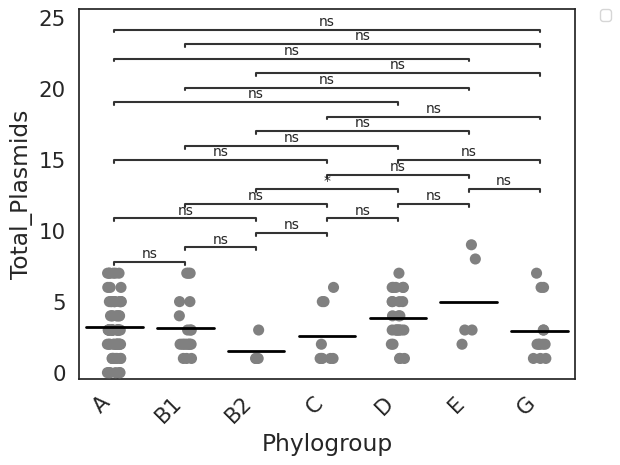

In [49]:
pairs = []

pairs2=[('A', 'B1'), ('A','B2'), ("A","C"), ("A", "D"), ("A", "E"), ("A", "G"), ("B1","B2"), ("B1", "C"), ("B1", "D"), ("B1", "E"), ("B1", "G"), ("B2", "C"), ("B2", "D"), ("B2", "E"), ("B2", "G"), ("C", "D"), ("C", "E"), ("C", "G"), ("D", "E"), ("D", "G"), ("E", "G")]

states_subcat =['A', 'B1', 'B2', 'C', 'D', 'E', 'G']
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': mobsuitephylodis, 'x': 'Phylogroup', 'y': 'Total_Plasmids', "order": states_subcat, "palette": state_palette}
    ax = sns.stripplot(x="Phylogroup", y="Total_Plasmids", data=mobsuitephylodis, size=8, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x= "Phylogroup",
            y="Total_Plasmids",
            data=mobsuitephylodis,
            showfliers=False,
            showbox=False,
            showcaps=False,
            order=states_subcat,
            ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofplasmidvsphylogroupdiseased.png", dpi = 400, bbox_inches= "tight")

In [ ]:
mobsuiteoutdis = mobsuite[~mobsuite['Source'].str.contains('Diseased')]
mobsuiteoutc = mobsuite[~mobsuite['Source'].str.contains('Cecal')]

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/statannotations/stats/StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F0012 vs. F0038: t-test independent samples, P_val:5.037e-01 t=-6.965e-01
F0038 vs. F0205: t-test independent samples, P_val:1.467e-01 t=1.573e+00
F0205 vs. F0731: t-test independent samples, P_val:3.574e-01 t=9.966e-01
F0731 vs. F23315: t-test independent samples, P_val:4.348e-03 t=-3.931e+00
F23315 vs. F2402: t-test independent samples, P_val:nan t=nan
F2402 vs. F3862: t-test independent samples, P_val:nan t=nan
F3862 vs. F4957: t-test independent samples, P_val:6.677e-02 t=2.500e+00
F4957 vs. F6041: t-test independent samples, P_val:5.140e-02 t=-2.288e+00
F6041 vs. F6245: t-test independent samples, P_val:6.148e-01 t=5.212e-01
F6245 vs. F7360: t-test independent samples, P_val:3.910e-01 t=-9.387e-01
F7360 vs. F8630: t-test independent samples, P_val:2.372e-02 t=-4.260e+00
F8630 vs. F9226: t-test independe

F0205 vs. F9503: t-test independent samples, P_val:5.232e-01 t=-6.777e-01
F0731 vs. F9619: t-test independent samples, P_val:2.099e-01 t=-1.492e+00
F0012 vs. F9413: t-test independent samples, P_val:7.272e-01 t=3.690e-01
F0038 vs. F9503: t-test independent samples, P_val:9.693e-01 t=3.976e-02
F0205 vs. F9619: t-test independent samples, P_val:3.673e-01 t=-9.749e-01
F0012 vs. F9503: t-test independent samples, P_val:8.110e-01 t=-2.521e-01
F0038 vs. F9619: t-test independent samples, P_val:7.972e-01 t=-2.657e-01
F0012 vs. F9619: t-test independent samples, P_val:6.337e-01 t=-5.071e-01


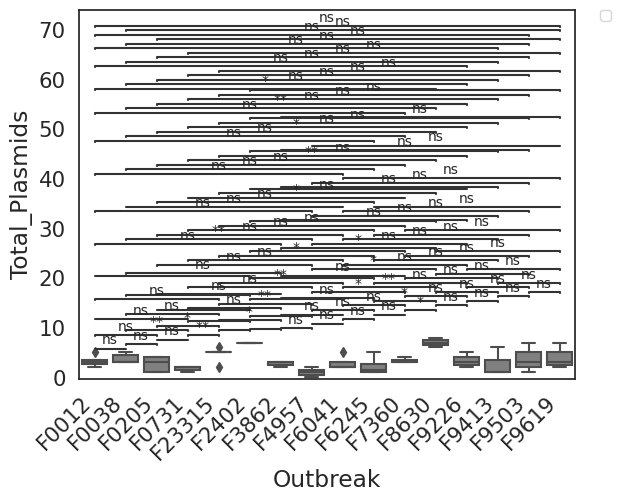

In [55]:
pairs = []

states_subcat =['F0012', 'F0038', 'F0205', 'F0731', 'F23315', 'F2402', 'F3862', 'F4957', 'F6041', 'F6245', 'F7360', 'F8630', 'F9226', 'F9413', 'F9503', 'F9619']
pairs2 = list(combinations(states_subcat, 2))
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': mobsuiteoutdis, 'x': 'Outbreak', 'y': 'Total_Plasmids', "order": states_subcat, "palette": state_palette}
    ax = sns.boxplot(x="Outbreak", y="Total_Plasmids", data=mobsuiteoutdis, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
#sns.boxplot(showmeans=True,
            #meanline=False,
            #meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            #medianprops={'visible': False},
            #whiskerprops={'visible': False},
            #zorder=10,
            #x= "Outbreak",
            #y="Total_Plasmids",
            #data=mobsuiteSUM,
            #showfliers=False,
            #showbox=False,
            #showcaps=False,
            #order=states_subcat,
            #ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofplasmidvsoutbreak_diseased.png", dpi = 400, bbox_inches= "tight")

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/statannotations/stats/StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F0012 vs. F0038: t-test independent samples, P_val:1.857e-01 t=1.494e+00
F0038 vs. F0205: t-test independent samples, P_val:8.824e-03 t=-3.440e+00
F0205 vs. F0731: t-test independent samples, P_val:6.942e-01 t=-4.077e-01
F0731 vs. F23315: t-test independent samples, P_val:8.963e-01 t=1.371e-01
F23315 vs. F2402: t-test independent samples, P_val:2.221e-01 t=1.444e+00
F2402 vs. F2655: t-test independent samples, P_val:8.450e-02 t=-2.065e+00
F2655 vs. F3862: t-test independent samples, P_val:3.077e-03 t=4.421e+00
F3862 vs. F4957: t-test independent samples, P_val:2.695e-02 t=-2.789e+00
F4957 vs. F4984: t-test independent samples, P_val:1.023e-02 t=-4.009e+00
F4984 vs. F6041: t-test independent samples, P_val:1.958e-02 t=3.771e+00
F6041 vs. F6245: t-test independent samples, P_val:1.382e-01 t=-1.647e+00
F6245 vs

F3862 vs. F9226: t-test independent samples, P_val:5.326e-02 t=-2.165e+00
F4957 vs. F9413: t-test independent samples, P_val:4.927e-01 t=-7.151e-01
F4984 vs. F9503: t-test independent samples, P_val:2.708e-03 t=6.615e+00
F6041 vs. F9619: t-test independent samples, P_val:6.145e-01 t=-5.199e-01
F0012 vs. F4984: t-test independent samples, P_val:3.372e-01 t=-1.089e+00
F0038 vs. F6041: t-test independent samples, P_val:7.049e-01 t=-3.974e-01
F0205 vs. F6245: t-test independent samples, P_val:3.969e-01 t=8.851e-01
F0731 vs. F7360: t-test independent samples, P_val:3.322e-01 t=-1.073e+00
F23315 vs. F7578: t-test independent samples, P_val:2.374e-02 t=2.877e+00
F2402 vs. F8630: t-test independent samples, P_val:4.816e-01 t=-7.500e-01
F2655 vs. F9226: t-test independent samples, P_val:1.685e-01 t=1.466e+00
F3862 vs. F9413: t-test independent samples, P_val:1.261e-02 t=-3.200e+00
F4957 vs. F9503: t-test independent samples, P_val:4.231e-03 t=4.162e+00
F4984 vs. F9619: t-test independent sample

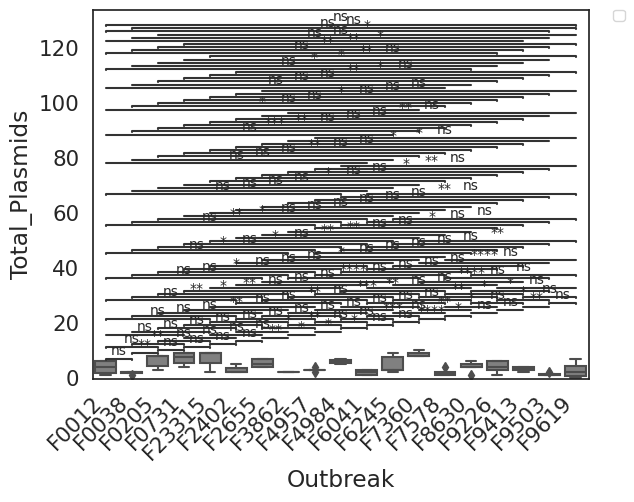

In [56]:
pairs = []

states_subcat =['F0012', 'F0038', 'F0205', 'F0731', 'F23315', 'F2402', 'F2655', 'F3862', 'F4957', 'F4984', 'F6041', 'F6245', 'F7360', 'F7578', 'F8630', 'F9226', 'F9413', 'F9503', 'F9619']
pairs2 = list(combinations(states_subcat, 2))
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': mobsuiteoutc, 'x': 'Outbreak', 'y': 'Total_Plasmids', "order": states_subcat, "palette": state_palette}
    ax = sns.boxplot(x="Outbreak", y="Total_Plasmids", data=mobsuiteoutc, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
#sns.boxplot(showmeans=True,
            #meanline=False,
            #meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            #medianprops={'visible': False},
            #whiskerprops={'visible': False},
            #zorder=10,
            #x= "Outbreak",
            #y="Total_Plasmids",
            #data=mobsuiteSUM,
            #showfliers=False,
            #showbox=False,
            #showcaps=False,
            #order=states_subcat,
            #ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofplasmidvsoutbreak_cecal.png", dpi = 400, bbox_inches= "tight")

In [58]:
AMRphylodis = AMRphylo[~AMRphylo['Source'].str.contains('Diseased')]
AMRphyloc = AMRphylo[~AMRphylo['Source'].str.contains('Cecal')]
AMRphyloe = AMRphylo[~AMRphylo['Source'].str.contains('Environmental')]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B1: t-test independent samples, P_val:1.880e-01 t=1.327e+00
B1 vs. B2: t-test independent samples, P_val:4.298e-01 t=-8.044e-01
B2 vs. C: t-test independent samples, P_val:8.275e-01 t=2.231e-01
C vs. D: t-test independent samples, P_val:2.004e-01 t=-1.306e+00
D vs. E: t-test independent samples, P_val:8.509e-01 t=1.897e-01
E vs. G: t-test independent samples, P_val:1.237e-01 t=-1.625e+00
A vs. B2: t-test independent samples, P_val:9.105e-01 t=-1.128e-01
B1 vs. C: t-test independent samples, P_val:3.758e-01 t=-9.006e-01
B2 vs. D: t-test independent samples, P_val:4.388e-01 t=-7.854e-01
C vs. E: t-test independent samples, P_val:1.309e-02 t=-2.910e+00
D vs. G: t-test independent samples, P_val:8.157e-02 t=-1.790e+00
A vs. C: t-test independent samples, P_val:8.893e-01 t=1.397e-01
B1 vs. D: t-test indepen

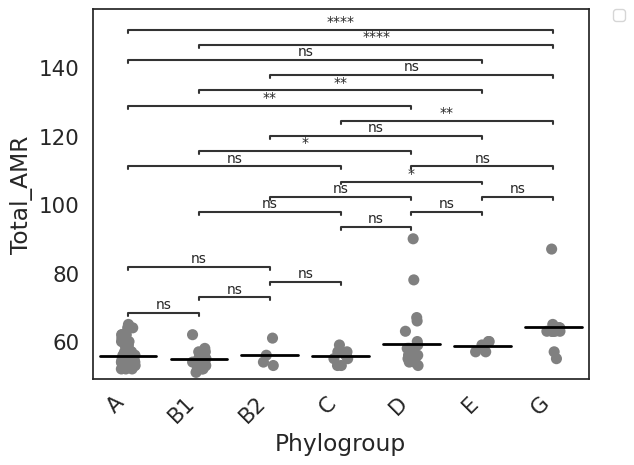

In [60]:
pairs = []

pairs2=[('A', 'B1'), ('A','B2'), ("A","C"), ("A", "D"), ("A", "E"), ("A", "G"), ("B1","B2"), ("B1", "C"), ("B1", "D"), ("B1", "E"), ("B1", "G"), ("B2", "C"), ("B2", "D"), ("B2", "E"), ("B2", "G"), ("C", "D"), ("C", "E"), ("C", "G"), ("D", "E"), ("D", "G"), ("E", "G")]

states_subcat =['A', 'B1', 'B2', 'C', 'D', 'E', 'G']
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': AMRphylodis, 'x': 'Phylogroup', 'y': 'Total_AMR', "order": states_subcat, "palette": state_palette}
    ax = sns.stripplot(x="Phylogroup", y="Total_AMR", data=AMRphylodis, size=8, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x= "Phylogroup",
            y="Total_AMR",
            data=AMRphylodis,
            showfliers=False,
            showbox=False,
            showcaps=False,
            order=states_subcat,
            ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofAMRvsphylogroupdiseased.png", dpi = 400, bbox_inches= "tight")

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/statannotations/stats/StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B1: t-test independent samples, P_val:1.721e-02 t=2.439e+00
B1 vs. B2: t-test independent samples, P_val:4.613e-01 t=-7.460e-01
B2 vs. C: t-test independent samples, P_val:6.630e-01 t=-4.415e-01
C vs. D: t-test independent samples, P_val:7.195e-02 t=-1.848e+00
D vs. E: t-test independent samples, P_val:9.636e-01 t=4.598e-02
E vs. G: t-test independent samples, P_val:7.315e-01 t=3.455e-01
A vs. B2: t-test independent samples, P_val:8.372e-02 t=1.754e+00
B1 vs. C: t-test independent samples, P_val:2.889e-01 t=-1.087e+00
B2 vs. D: t-test independent samples, P_val:5.819e-03 t=-2.884e+00
C vs. E: t-test independent samples, P_val:5.276e-03 t=-3.795e+00
D vs. G: t-test independent samples, P_val:4.148e-01 t=8.202e-01
A vs. C: t-test independent samples, P_val:3.613e-01 t=9.196e-01
B1 vs. D: t-test independe

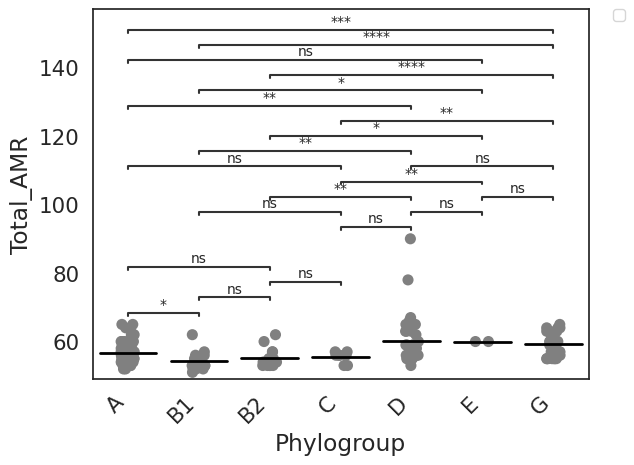

In [61]:
pairs = []

pairs2=[('A', 'B1'), ('A','B2'), ("A","C"), ("A", "D"), ("A", "E"), ("A", "G"), ("B1","B2"), ("B1", "C"), ("B1", "D"), ("B1", "E"), ("B1", "G"), ("B2", "C"), ("B2", "D"), ("B2", "E"), ("B2", "G"), ("C", "D"), ("C", "E"), ("C", "G"), ("D", "E"), ("D", "G"), ("E", "G")]

states_subcat =['A', 'B1', 'B2', 'C', 'D', 'E', 'G']
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': AMRphyloc, 'x': 'Phylogroup', 'y': 'Total_AMR', "order": states_subcat, "palette": state_palette}
    ax = sns.stripplot(x="Phylogroup", y="Total_AMR", data=AMRphyloc, size=8, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x= "Phylogroup",
            y="Total_AMR",
            data=AMRphyloc,
            showfliers=False,
            showbox=False,
            showcaps=False,
            order=states_subcat,
            ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofAMRvsphylogroup_cecal.png", dpi = 400, bbox_inches= "tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B1: t-test independent samples, P_val:1.186e-03 t=3.394e+00
B1 vs. B2: t-test independent samples, P_val:7.811e-02 t=-1.812e+00
B2 vs. C: t-test independent samples, P_val:4.090e-01 t=-8.392e-01
C vs. D: t-test independent samples, P_val:4.422e-02 t=-2.129e+00
D vs. E: t-test independent samples, P_val:5.185e-01 t=6.579e-01
E vs. G: t-test independent samples, P_val:7.758e-01 t=-2.870e-01
A vs. B2: t-test independent samples, P_val:2.090e-01 t=1.268e+00
B1 vs. C: t-test independent samples, P_val:1.603e-02 t=-2.599e+00
B2 vs. D: t-test independent samples, P_val:4.780e-04 t=-3.831e+00
C vs. E: t-test independent samples, P_val:1.279e-01 t=-1.698e+00
D vs. G: t-test independent samples, P_val:7.734e-01 t=2.895e-01
A vs. C: t-test independent samples, P_val:9.691e-01 t=-3.896e-02
B1 vs. D: t-test indepen

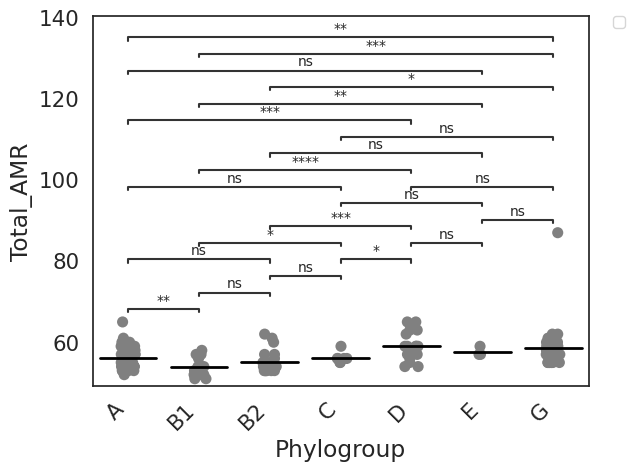

In [62]:
pairs = []

pairs2=[('A', 'B1'), ('A','B2'), ("A","C"), ("A", "D"), ("A", "E"), ("A", "G"), ("B1","B2"), ("B1", "C"), ("B1", "D"), ("B1", "E"), ("B1", "G"), ("B2", "C"), ("B2", "D"), ("B2", "E"), ("B2", "G"), ("C", "D"), ("C", "E"), ("C", "G"), ("D", "E"), ("D", "G"), ("E", "G")]

states_subcat =['A', 'B1', 'B2', 'C', 'D', 'E', 'G']
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': AMRphyloe, 'x': 'Phylogroup', 'y': 'Total_AMR', "order": states_subcat, "palette": state_palette}
    ax = sns.stripplot(x="Phylogroup", y="Total_AMR", data=AMRphyloe, size=8, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x= "Phylogroup",
            y="Total_AMR",
            data=AMRphyloe,
            showfliers=False,
            showbox=False,
            showcaps=False,
            order=states_subcat,
            ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofAMRvsphylogroup_environmental.png", dpi = 400, bbox_inches= "tight")

In [63]:
VFphylodis = VFphylo[~VFphylo['Source'].str.contains('Diseased')]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B1: t-test independent samples, P_val:9.382e-01 t=7.778e-02
B1 vs. B2: t-test independent samples, P_val:1.201e-01 t=-1.617e+00
B2 vs. C: t-test independent samples, P_val:4.965e-01 t=7.033e-01
C vs. D: t-test independent samples, P_val:9.889e-01 t=1.402e-02
D vs. E: t-test independent samples, P_val:1.777e-02 t=-2.513e+00
E vs. G: t-test independent samples, P_val:3.456e-01 t=9.718e-01
A vs. B2: t-test independent samples, P_val:2.481e-01 t=-1.164e+00
B1 vs. C: t-test independent samples, P_val:7.089e-01 t=-3.773e-01
B2 vs. D: t-test independent samples, P_val:2.661e-01 t=1.135e+00
C vs. E: t-test independent samples, P_val:1.456e-01 t=-1.556e+00
D vs. G: t-test independent samples, P_val:2.630e-02 t=-2.314e+00
A vs. C: t-test independent samples, P_val:7.409e-01 t=-3.319e-01
B1 vs. D: t-test independ

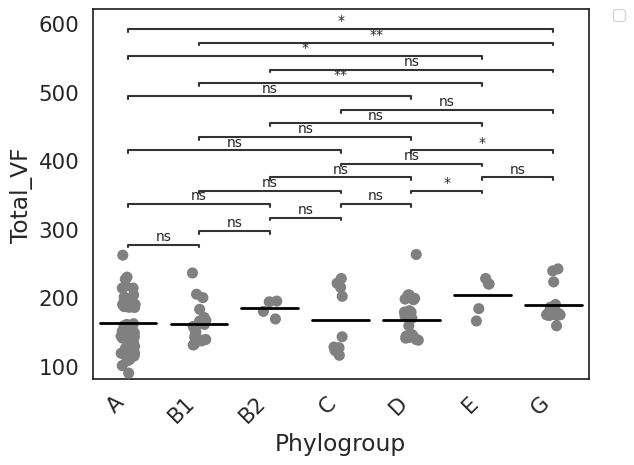

In [64]:
pairs = []

pairs2=[('A', 'B1'), ('A','B2'), ("A","C"), ("A", "D"), ("A", "E"), ("A", "G"), ("B1","B2"), ("B1", "C"), ("B1", "D"), ("B1", "E"), ("B1", "G"), ("B2", "C"), ("B2", "D"), ("B2", "E"), ("B2", "G"), ("C", "D"), ("C", "E"), ("C", "G"), ("D", "E"), ("D", "G"), ("E", "G")]

states_subcat =['A', 'B1', 'B2', 'C', 'D', 'E', 'G']
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': VFphylodis, 'x': 'Phylogroup', 'y': 'Total_VF', "order": states_subcat, "palette": state_palette}
    ax = sns.stripplot(x="Phylogroup", y="Total_VF", data=VFphylodis, size=8, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x= "Phylogroup",
            y="Total_VF",
            data=VFphylodis,
            showfliers=False,
            showbox=False,
            showcaps=False,
            order=states_subcat,
            ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofVFvsphylogroupdiseased.png", dpi = 400, bbox_inches= "tight")

In [65]:
VFoutdis = VF[~VF['Source'].str.contains('Diseased')]
VFoutc = VF[~VF['Source'].str.contains('Cecal')]

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/statannotations/stats/StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F0012 vs. F0038: t-test independent samples, P_val:2.625e-01 t=-1.195e+00
F0038 vs. F0205: t-test independent samples, P_val:2.581e-01 t=1.199e+00
F0205 vs. F0731: t-test independent samples, P_val:6.544e-04 t=6.456e+00
F0731 vs. F23315: t-test independent samples, P_val:6.820e-03 t=-3.616e+00
F23315 vs. F2402: t-test independent samples, P_val:nan t=nan
F2402 vs. F3862: t-test independent samples, P_val:nan t=nan
F3862 vs. F4957: t-test independent samples, P_val:5.139e-03 t=5.555e+00
F4957 vs. F6041: t-test independent samples, P_val:8.492e-02 t=1.966e+00
F6041 vs. F6245: t-test independent samples, P_val:2.860e-02 t=-2.603e+00
F6245 vs. F7360: t-test independent samples, P_val:2.009e-01 t=-1.472e+00
F7360 vs. F8630: t-test independent samples, P_val:6.021e-01 t=5.808e-01
F8630 vs. F9226: t-test independen

F0731 vs. F9619: t-test independent samples, P_val:6.532e-01 t=-4.847e-01
F0012 vs. F9413: t-test independent samples, P_val:4.262e-01 t=8.659e-01
F0038 vs. F9503: t-test independent samples, P_val:3.301e-01 t=1.037e+00
F0205 vs. F9619: t-test independent samples, P_val:5.817e-01 t=5.820e-01
F0012 vs. F9503: t-test independent samples, P_val:7.047e-01 t=-4.014e-01
F0038 vs. F9619: t-test independent samples, P_val:3.928e-01 t=9.031e-01
F0012 vs. F9619: t-test independent samples, P_val:9.666e-01 t=4.402e-02


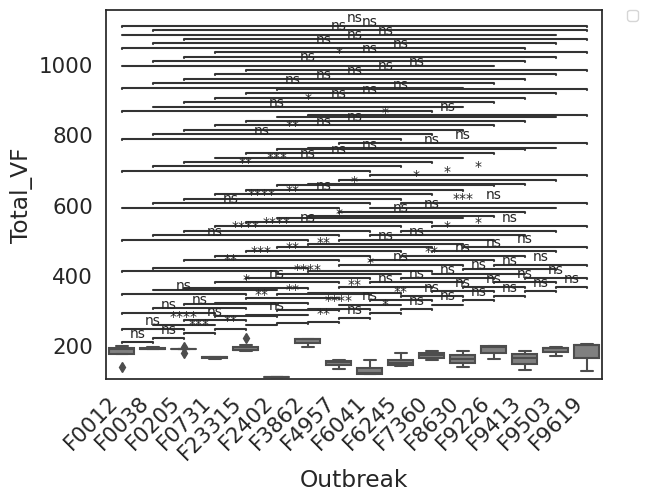

In [66]:
pairs = []

states_subcat =['F0012', 'F0038', 'F0205', 'F0731', 'F23315', 'F2402', 'F3862', 'F4957', 'F6041', 'F6245', 'F7360', 'F8630', 'F9226', 'F9413', 'F9503', 'F9619']
pairs2 = list(combinations(states_subcat, 2))
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': VFoutdis, 'x': 'Outbreak', 'y': 'Total_VF', "order": states_subcat, "palette": state_palette}
    ax = sns.boxplot(x="Outbreak", y="Total_VF", data=VFoutdis, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
#sns.boxplot(showmeans=True,
            #meanline=False,
            #meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            #medianprops={'visible': False},
            #whiskerprops={'visible': False},
            #zorder=10,
            #x= "Outbreak",
            #y="Total_Plasmids",
            #data=mobsuiteSUM,
            #showfliers=False,
            #showbox=False,
            #showcaps=False,
            #order=states_subcat,
            #ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofVFvsoutbreak_diseased.png", dpi = 400, bbox_inches= "tight")

/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/statannotations/stats/StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F0012 vs. F0038: t-test independent samples, P_val:2.403e-05 t=-1.166e+01
F0038 vs. F0205: t-test independent samples, P_val:1.646e-02 t=3.024e+00
F0205 vs. F0731: t-test independent samples, P_val:8.390e-03 t=3.474e+00
F0731 vs. F23315: t-test independent samples, P_val:2.856e-01 t=-1.195e+00
F23315 vs. F2402: t-test independent samples, P_val:2.330e-05 t=-2.245e+01
F2402 vs. F2655: t-test independent samples, P_val:2.854e-05 t=1.131e+01
F2655 vs. F3862: t-test independent samples, P_val:8.892e-02 t=-1.974e+00
F3862 vs. F4957: t-test independent samples, P_val:3.546e-01 t=-9.911e-01
F4957 vs. F4984: t-test independent samples, P_val:2.582e-01 t=1.275e+00
F4984 vs. F6041: t-test independent samples, P_val:4.344e-02 t=-2.915e+00
F6041 vs. F6245: t-test independent samples, P_val:3.764e-04 t=5.865e+00
F6245 vs

F4984 vs. F9503: t-test independent samples, P_val:2.185e-06 t=-4.067e+01
F6041 vs. F9619: t-test independent samples, P_val:9.946e-03 t=3.172e+00
F0012 vs. F4984: t-test independent samples, P_val:5.415e-01 t=6.667e-01
F0038 vs. F6041: t-test independent samples, P_val:1.855e-01 t=1.495e+00
F0205 vs. F6245: t-test independent samples, P_val:4.243e-04 t=5.162e+00
F0731 vs. F7360: t-test independent samples, P_val:4.967e-03 t=-4.781e+00
F23315 vs. F7578: t-test independent samples, P_val:5.067e-01 t=-6.998e-01
F2402 vs. F8630: t-test independent samples, P_val:2.875e-02 t=-2.861e+00
F2655 vs. F9226: t-test independent samples, P_val:1.153e-02 t=-2.978e+00
F3862 vs. F9413: t-test independent samples, P_val:6.204e-01 t=5.151e-01
F4957 vs. F9503: t-test independent samples, P_val:9.237e-01 t=9.934e-02
F4984 vs. F9619: t-test independent samples, P_val:5.516e-01 t=6.214e-01
F0012 vs. F6041: t-test independent samples, P_val:1.055e-02 t=-3.662e+00
F0038 vs. F6245: t-test independent samples,

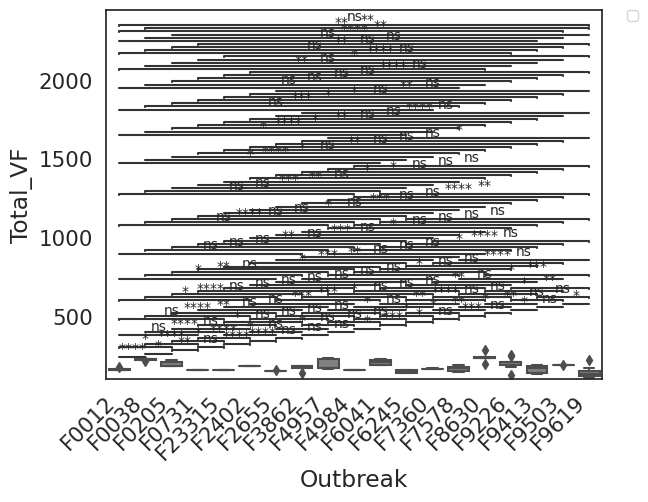

In [67]:
pairs = []

states_subcat =['F0012', 'F0038', 'F0205', 'F0731', 'F23315', 'F2402', 'F2655', 'F3862', 'F4957', 'F4984', 'F6041', 'F6245', 'F7360', 'F7578', 'F8630', 'F9226', 'F9413', 'F9503', 'F9619']
pairs2 = list(combinations(states_subcat, 2))
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': VFoutc, 'x': 'Outbreak', 'y': 'Total_VF', "order": states_subcat, "palette": state_palette}
    ax = sns.boxplot(x="Outbreak", y="Total_VF", data=VFoutc, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
#sns.boxplot(showmeans=True,
            #meanline=False,
            #meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            #medianprops={'visible': False},
            #whiskerprops={'visible': False},
            #zorder=10,
            #x= "Outbreak",
            #y="Total_Plasmids",
            #data=mobsuiteSUM,
            #showfliers=False,
            #showbox=False,
            #showcaps=False,
            #order=states_subcat,
            #ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofVFvsoutbreak_cecal.png", dpi = 400, bbox_inches= "tight")

In [68]:
BACMETphylodis = BACMETphylo[~BACMETphylo['Source'].str.contains('Diseased')]
BACMETphyloc = BACMETphylo[~BACMETphylo['Source'].str.contains('Cecal')]


/home/haley/miniconda3/envs/jupyter/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B1: t-test independent samples, P_val:4.224e-01 t=8.059e-01
B1 vs. B2: t-test independent samples, P_val:4.526e-01 t=7.647e-01
B2 vs. C: t-test independent samples, P_val:1.831e-01 t=-1.421e+00
C vs. D: t-test independent samples, P_val:8.743e-01 t=-1.595e-01
D vs. E: t-test independent samples, P_val:9.079e-01 t=-1.167e-01
E vs. G: t-test independent samples, P_val:2.274e-01 t=-1.255e+00
A vs. B2: t-test independent samples, P_val:2.115e-01 t=1.260e+00
B1 vs. C: t-test independent samples, P_val:9.956e-01 t=5.547e-03
B2 vs. D: t-test independent samples, P_val:4.178e-01 t=-8.223e-01
C vs. E: t-test independent samples, P_val:6.676e-01 t=-4.402e-01
D vs. G: t-test independent samples, P_val:3.418e-02 t=-2.199e+00
A vs. C: t-test independent samples, P_val:5.393e-01 t=6.166e-01
B1 vs. D: t-test independ

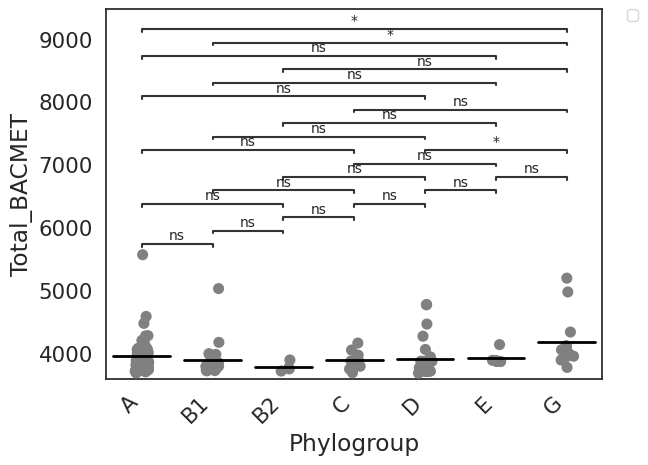

In [70]:
pairs = []

pairs2=[('A', 'B1'), ('A','B2'), ("A","C"), ("A", "D"), ("A", "E"), ("A", "G"), ("B1","B2"), ("B1", "C"), ("B1", "D"), ("B1", "E"), ("B1", "G"), ("B2", "C"), ("B2", "D"), ("B2", "E"), ("B2", "G"), ("C", "D"), ("C", "E"), ("C", "G"), ("D", "E"), ("D", "G"), ("E", "G")]

states_subcat =['A', 'B1', 'B2', 'C', 'D', 'E', 'G']
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': BACMETphylodis, 'x': 'Phylogroup', 'y': 'Total_BACMET', "order": states_subcat, "palette": state_palette}
    ax = sns.stripplot(x="Phylogroup", y="Total_BACMET", data=BACMETphylodis, size=8, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x= "Phylogroup",
            y="Total_BACMET",
            data=BACMETphylodis,
            showfliers=False,
            showbox=False,
            showcaps=False,
            order=states_subcat,
            ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofBACMETvsphylogroupdiseased.png", dpi = 400, bbox_inches= "tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B1: t-test independent samples, P_val:6.149e-01 t=5.053e-01
B1 vs. B2: t-test independent samples, P_val:6.109e-01 t=5.139e-01
B2 vs. C: t-test independent samples, P_val:8.900e-01 t=-1.398e-01
C vs. D: t-test independent samples, P_val:3.146e-01 t=-1.018e+00
D vs. E: t-test independent samples, P_val:7.036e-01 t=3.836e-01
E vs. G: t-test independent samples, P_val:6.260e-01 t=-4.910e-01
A vs. B2: t-test independent samples, P_val:2.300e-01 t=1.211e+00
B1 vs. C: t-test independent samples, P_val:7.597e-01 t=3.097e-01
B2 vs. D: t-test independent samples, P_val:1.379e-01 t=-1.508e+00
C vs. E: t-test independent samples, P_val:7.626e-01 t=-3.126e-01
D vs. G: t-test independent samples, P_val:9.181e-01 t=-1.032e-01
A vs. C: t-test independent samples, P_val:4.432e-01 t=7.717e-01
B1 vs. D: t-test independe

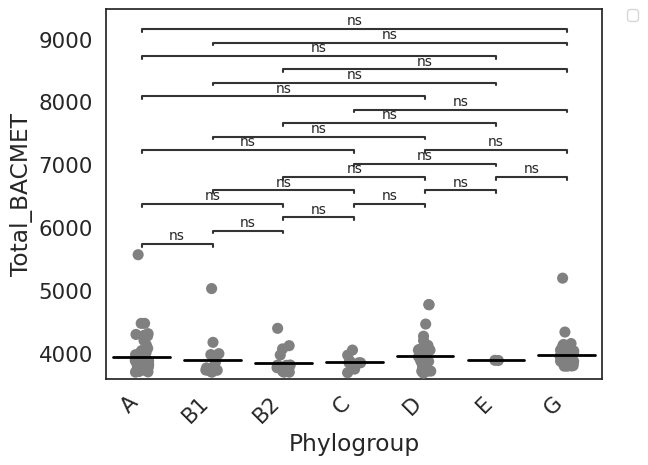

In [71]:
pairs = []

pairs2=[('A', 'B1'), ('A','B2'), ("A","C"), ("A", "D"), ("A", "E"), ("A", "G"), ("B1","B2"), ("B1", "C"), ("B1", "D"), ("B1", "E"), ("B1", "G"), ("B2", "C"), ("B2", "D"), ("B2", "E"), ("B2", "G"), ("C", "D"), ("C", "E"), ("C", "G"), ("D", "E"), ("D", "G"), ("E", "G")]

states_subcat =['A', 'B1', 'B2', 'C', 'D', 'E', 'G']
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': BACMETphyloc, 'x': 'Phylogroup', 'y': 'Total_BACMET', "order": states_subcat, "palette": state_palette}
    ax = sns.stripplot(x="Phylogroup", y="Total_BACMET", data=BACMETphyloc, size=8, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x= "Phylogroup",
            y="Total_BACMET",
            data=BACMETphyloc,
            showfliers=False,
            showbox=False,
            showcaps=False,
            order=states_subcat,
            ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofBACMETvsphylogroup_cecal.png", dpi = 400, bbox_inches= "tight")

In [72]:
BACMEToutc = BACMET[~BACMET['Source'].str.contains('Cecal')]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F0012 vs. F0038: t-test independent samples, P_val:4.644e-01 t=-7.812e-01
F0038 vs. F0205: t-test independent samples, P_val:1.352e-01 t=-1.662e+00
F0205 vs. F0731: t-test independent samples, P_val:1.719e-01 t=-1.501e+00
F0731 vs. F23315: t-test independent samples, P_val:8.502e-06 t=1.850e+01
F23315 vs. F2402: t-test independent samples, P_val:4.249e-05 t=-1.930e+01
F2402 vs. F2655: t-test independent samples, P_val:2.646e-02 t=2.925e+00
F2655 vs. F3862: t-test independent samples, P_val:1.345e-01 t=-1.692e+00
F3862 vs. F4957: t-test independent samples, P_val:1.845e-01 t=1.472e+00
F4957 vs. F4984: t-test independent samples, P_val:3.900e-01 t=9.409e-01
F4984 vs. F6041: t-test independent samples, P_val:1.158e-01 t=-2.003e+00
F6041 vs. F6245: t-test independent samples, P_val:1.539e-02 t=3.068e+00
F6245 vs

F4984 vs. F9503: t-test independent samples, P_val:6.401e-01 t=-5.050e-01
F6041 vs. F9619: t-test independent samples, P_val:5.784e-01 t=5.744e-01
F0012 vs. F4984: t-test independent samples, P_val:7.551e-01 t=3.341e-01
F0038 vs. F6041: t-test independent samples, P_val:4.489e-02 t=-2.526e+00
F0205 vs. F6245: t-test independent samples, P_val:8.382e-02 t=1.920e+00
F0731 vs. F7360: t-test independent samples, P_val:8.050e-02 t=2.186e+00
F23315 vs. F7578: t-test independent samples, P_val:8.362e-01 t=-2.146e-01
F2402 vs. F8630: t-test independent samples, P_val:3.912e-01 t=9.239e-01
F2655 vs. F9226: t-test independent samples, P_val:5.694e-01 t=-5.850e-01
F3862 vs. F9413: t-test independent samples, P_val:8.711e-01 t=-1.675e-01
F4957 vs. F9503: t-test independent samples, P_val:8.460e-01 t=-2.015e-01
F4984 vs. F9619: t-test independent samples, P_val:6.117e-01 t=-5.282e-01
F0012 vs. F6041: t-test independent samples, P_val:2.643e-02 t=-2.926e+00
F0038 vs. F6245: t-test independent sample

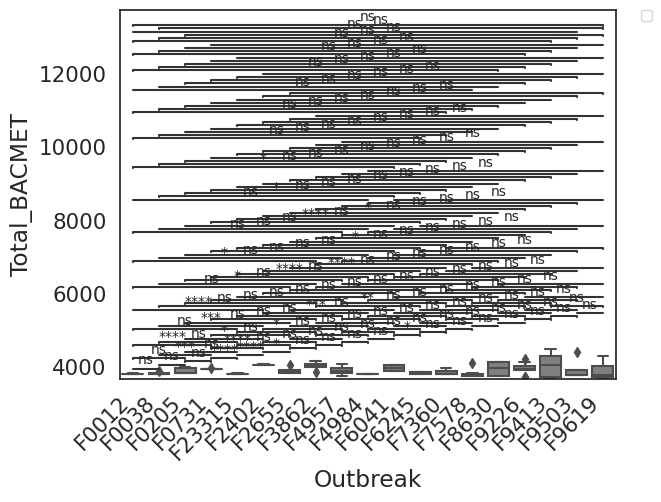

In [74]:
pairs = []

states_subcat =['F0012', 'F0038', 'F0205', 'F0731', 'F23315', 'F2402', 'F2655', 'F3862', 'F4957', 'F4984', 'F6041', 'F6245', 'F7360', 'F7578', 'F8630', 'F9226', 'F9413', 'F9503', 'F9619']
pairs2 = list(combinations(states_subcat, 2))
sns.set_style(style='white') 
state_palette = "colorblind"

with sns.plotting_context('notebook', font_scale = 1.4): 
    #Create new plot 
    hue_plot_params = {'data': BACMEToutc, 'x': 'Outbreak', 'y': 'Total_BACMET', "order": states_subcat, "palette": state_palette}
    ax = sns.boxplot(x="Outbreak", y="Total_BACMET", data=BACMEToutc, order=states_subcat, palette=['grey'])
plt.xticks(rotation=45, ha="right")


# plot the mean line
#sns.boxplot(showmeans=True,
            #meanline=False,
            #meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            #medianprops={'visible': False},
            #whiskerprops={'visible': False},
            #zorder=10,
            #x= "Outbreak",
            #y="Total_Plasmids",
            #data=mobsuiteSUM,
            #showfliers=False,
            #showbox=False,
            #showcaps=False,
            #order=states_subcat,
            #ax=ax)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#annotating with pairs
annot = Annotator(ax, pairs2, **hue_plot_params)
annot.configure(test='t-test_ind', verbose=2)
annot.apply_test()
annot.annotate()

plt.savefig("05292023_EcoliARETE_sumofBACMETvsoutbreak_cecal.png", dpi = 400, bbox_inches= "tight")